In [12]:
import os #  using Python to interact with the operating system
from glob import glob #find all the pathnames matching a specified pattern according to the rules used by the Unix shell
import numpy as np
import cv2 # read image

import torch # work with PyTorch, a  deep learning library
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
#
!pip install segmentation-models-pytorch
import segmentation_models_pytorch as smp #smp library is a collection of pre-trained models for image segmentation
import albumentations as A # image augmentation library that can be used to perform various image transformations.
from albumentations.pytorch import ToTensorV2 #The ToTensorV2 transform from albumentations.pytorch is used to convert images and masks to PyTorch tensors

import skimage # a collection of algorithms for image processing
!pip install torchmetrics
import torchmetrics
from torchmetrics import Dice, JaccardIndex

from tqdm import tqdm
import matplotlib.pyplot as plt

In [13]:

class SegmentationDataset(Dataset):
    """Generate Semantic Segmentation Dataset through the following steps:
      - Read images/ masks from path_name
      - Apply augmentations and Normalization
      - Process transformations
    Input:
        Dataset (image): Images
    Output: Dataset with transformed_image, transformed_mask (if transformation is applied)
     or image_tensor, mask_tensor (if transformation is not applied)  in tensor type
    """
    def __init__(self, path_name, transform=None):
        super().__init__()
        self.transform = transform
        self.image_names = os.listdir(f"{path_name}/images")
        self.image_paths = [f"{path_name}/images/{i}" for i in self.image_names]
        self.masks_names = os.listdir(f"{path_name}/masks")
        self.masks_paths = [f"{path_name}/masks/{i}" for i in self.masks_names]

        # Check and save only images and masks that are existing in equivalent folders
        self.img_stem = [Path(i).stem for i in self.image_paths]
        self.msk_stem = [Path(i).stem for i in self.masks_paths]
        self.img_msk_stem = set(self.img_stem) & set(self.msk_stem)
        self.image_paths = [i for i in self.image_paths if (Path(i).stem in self.img_msk_stem)]


    def __len__(self):
        return len(self.img_msk_stem)

    def __getitem__(self, index):

        image = cv2.imread(self.image_paths[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask =  cv2.imread(self.masks_paths[index], cv2.IMREAD_GRAYSCALE)
        mask[mask >=2]= 1 # if boundary >= 2, then convert its pixel value to 1
        if self.transform is not None:
         transformed = self.transform(image = image, mask=mask)
         transformed_image = transformed['image']
         transformed_mask = transformed['mask']
         return transformed_image, transformed_mask
        else:
         image = image.transpose((2, 0, 1))  #structure: BS, C, H, W
         image_tensor = torch.tensor(image)
         mask_tensor = torch.tensor(mask)
         return image_tensor, mask_tensor

In [14]:
# Image Augementations and Normalization through Transformation
trainsize =256
train_transform = A.Compose([A.Resize(width = trainsize, height= trainsize), A.HorizontalFlip(),
                             A.RandomBrightnessContrast(),A.Blur(), A.RGBShift(),
                             A.Sharpen(),
                             A.Normalize (mean =(0.485,0.456,0.406), std =(0.229,0.224,0.225), max_pixel_value=255.0),ToTensorV2()])
val_transform = A.Compose([A.Resize(width = trainsize, height= trainsize),A.Normalize (mean =(0.485,0.456,0.406), std =(0.229,0.224,0.225), max_pixel_value=255.0),ToTensorV2()])

In [15]:
import torch
import torch.nn as nn

# Convolution + ReLU layers computation
def unet_layer(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True))

# Construct U-net model
class UNet(nn.Module):
    def __init__(self, n_classes):
        super(UNet, self).__init__()
        self.n_classes = n_classes

        # Define Downsampling layer
        self.downsample = nn.MaxPool2d(2)

        # Define convolution + ReLU layers in encoder path
        self.layer_down1 = unet_layer(3, 64)
        self.layer_down2 = unet_layer(64, 128)
        self.layer_down3 = unet_layer(128, 256)
        self.layer_down4 = unet_layer(256, 512)

        #
        self.layer_neck = unet_layer(512, 1024)

        # Define upsampling blocks with transposed convolutions
        self.upsample1 = nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1)
        self.upsample2 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1)
        self.upsample3 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.upsample4 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)

        # Define convolution + ReLU layers in decoder path
        self.layer_up1 = unet_layer(1024, 512)
        self.layer_up2 = unet_layer(512, 256)
        self.layer_up3 = unet_layer(256, 128)
        self.layer_up4 = unet_layer(128, 64)

        # Segmentation output map
        self.conv_cls = nn.Conv2d(64, self.n_classes, kernel_size=1)

    def forward(self, x):
        # Encoder Path with 2 Convolutions and Downsampling
        out1 = self.layer_down1(x)
        x = self.downsample(out1)
        out2 = self.layer_down2(x)
        x = self.downsample(out2)
        out3 = self.layer_down3(x)
        x = self.downsample(out3)
        out4 = self.layer_down4(x)
        x = self.downsample(out4)

        # Bottleneck layer
        x = self.layer_neck(x)

        # Decoder Path with Upsampling, Concatenating and Convolutions
        x = self.upsample1(x)
        x = torch.cat([out4, x], dim=1)
        x = self.layer_up1(x)

        x = self.upsample2(x)
        x = torch.cat([out3, x], dim=1)
        x = self.layer_up2(x)

        x = self.upsample3(x)
        x = torch.cat([out2, x], dim=1)
        x = self.layer_up3(x)

        x = self.upsample4(x)
        x = torch.cat([out1, x], dim=1)
        x = self.layer_up4(x)

        # Final classification layer
        x = self.conv_cls(x)
        return x


In [16]:
class AverageMeter(object):
    """This class for keeping track of the average value of a metric (e.g., loss, accuracy, IOU, DICE) over multiple batches or epochs."""

    def __init__(self):
        self.reset()

    def reset(self):
        """Reset all meters"""
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        """Updates the meter with a new value"""
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Accuracy Function
"""This function is used for measuring the nf1 severity in the given image"""
def nf1_density(mask):
    total_area = mask.size(0)*mask.size(1) # calculate the to the total number of pixels in the 2D mask
    mask = mask.flatten() # Flatten the mask to a 1D tensor
    nf1 = torch.sum(mask == 1)  # Count the number of pixels where NF1 is present
    density = (nf1/total_area)*100 # Calculate the density as a percentage
    return density

In [17]:
# Define Class
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    def __call__(self,tensor):
        """
        Args: tensor(Tensor): Tensor image of size (C,H, W) to be un-normalized.
        Returns:
        Tensor: Un-Normolized image'
        """
        # mean and std are converted to tensors and then unsqueezed to match the dimensions of the tensor
        mean = torch.tensor(self.mean).unsqueeze(-1).unsqueeze(-1)
        std = torch.tensor(self.std).unsqueeze(-1).unsqueeze(-1)
        unnorm_tensor = tensor.clone()  # To avoid modifying the original tensor
        unnorm_tensor.mul_(std).add_(mean)
        return unnorm_tensor

In [18]:
# Check device for training
device = "cuda" if torch.cuda.is_available() else "cpu"

# Binary Classification with Unet model
model = UNet(1).to(device)

# Define the path to the test folder
# Return the current working directory (CWD) of the script that is being executed
root_path = os.getcwd()  
print(root_path)

c:\course22\Thesis_NF1Project_TuongHieuHuynh\upload


In [19]:
# LOAD WEIGHTS FROM TRAINED MODEL

#Get the absolute path to the file
import torch
# Call the path where the trained model file is saved. Here it is save in "model" folder
file_path = os.path.abspath('model/model_ep584.pth')
print(file_path)

# Load the weights from trained_model
model.load_state_dict(torch.load(file_path, map_location=torch.device('cpu')))

c:\course22\Thesis_NF1Project_TuongHieuHuynh\upload\model\model_ep584.pth


<All keys matched successfully>

In [20]:
# LOSS
# Define Binary Cross-Entropy Loss function
criterion = nn.BCEWithLogitsLoss()

# OPTIMIZER: Adam optimizer
optimizer = torch.optim.Adam(model.parameters(),lr =1e-4)

# EVALUATION FUNCTIONS: define DICE and IOU function from library
dice_function = torchmetrics.Dice(num_classes=2, average= "macro").to(device)
iou_function= torchmetrics.JaccardIndex(num_classes=2,task="binary", average= "macro").to(device)

#METER

# DICE and IOU METERS during validation
dice_meter = AverageMeter()

iou_meter =AverageMeter()

# NF1 SEVERITY MEASUREMENT METER during validation

density_meter = AverageMeter()


c:\course22\Thesis_NF1Project_TuongHieuHuynh\upload
c:\course22\Thesis_NF1Project_TuongHieuHuynh\upload/test_All
NF1 SEVERITY IN 100%:  PREDICTED=2.314394950866699


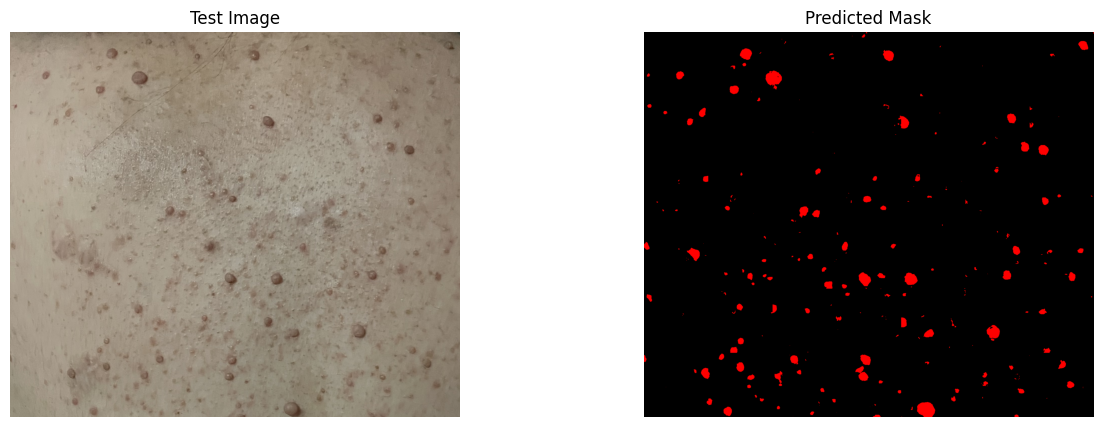

c:\course22\Thesis_NF1Project_TuongHieuHuynh\upload
c:\course22\Thesis_NF1Project_TuongHieuHuynh\upload/test_All
NF1 SEVERITY IN 100%:  PREDICTED=1.0582787990570068


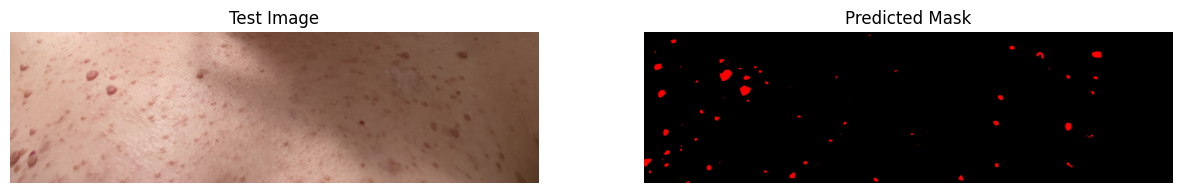

c:\course22\Thesis_NF1Project_TuongHieuHuynh\upload
c:\course22\Thesis_NF1Project_TuongHieuHuynh\upload/test_All
NF1 SEVERITY IN 100%:  PREDICTED=1.2003326416015625


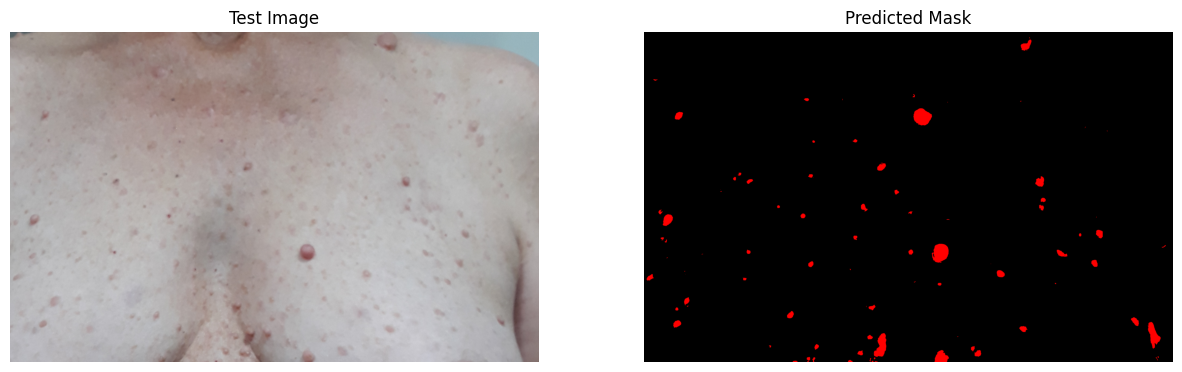

c:\course22\Thesis_NF1Project_TuongHieuHuynh\upload
c:\course22\Thesis_NF1Project_TuongHieuHuynh\upload/test_All
NF1 SEVERITY IN 100%:  PREDICTED=0.3526051938533783


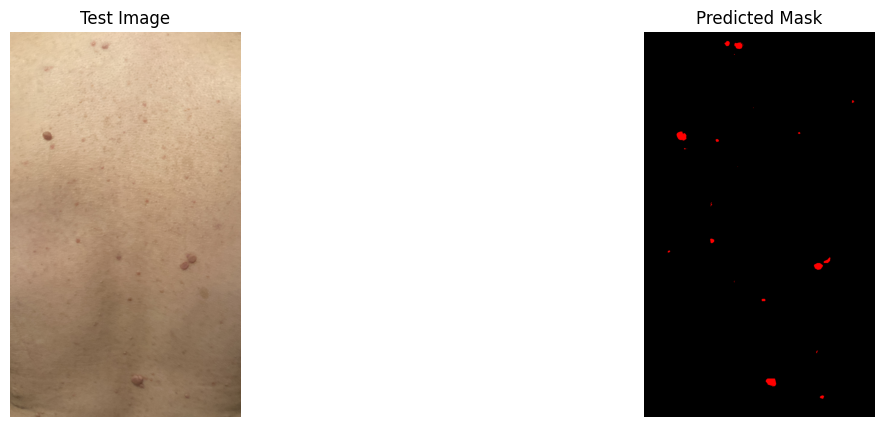

c:\course22\Thesis_NF1Project_TuongHieuHuynh\upload
c:\course22\Thesis_NF1Project_TuongHieuHuynh\upload/test_All
NF1 SEVERITY IN 100%:  PREDICTED=6.567626953125


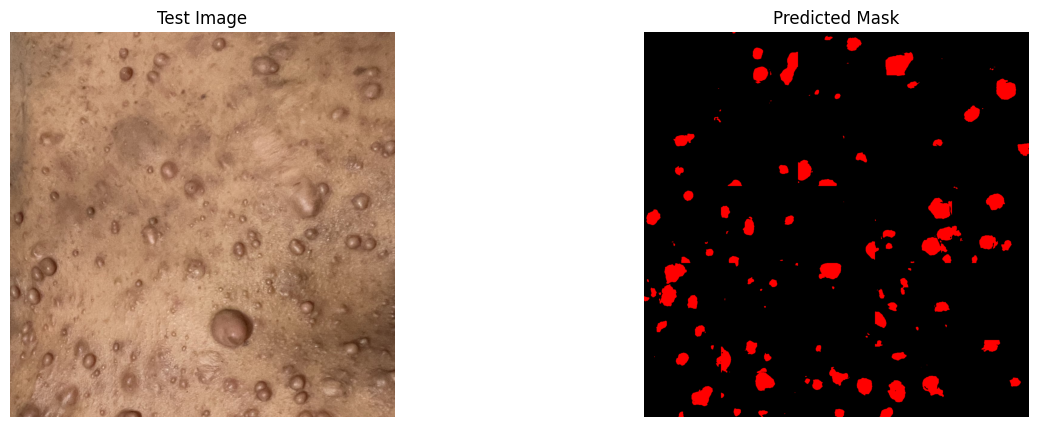

In [24]:
# GUI1 for PRACTICAL APPLICATION
# GUI1 for testing image with any sizes of 256x256 multiples such as 256x512, 512x768, 512x512
# Put a test image in the folder" test_All" 
# To have the good accuracy of the result, the image test size should be multiples of 256x256
# The GUI will output the predicted mask
# Save the predicted mask and then review it.
# The display will show the NF1 severity immediately after saving it.
import tkinter as tk
from tkinter import filedialog, messagebox
from PIL import Image, ImageTk
import cv2
import numpy as np
from patchify import patchify, unpatchify
import torch

density_meter.reset()

class ImageDisplay:
    def __init__(self, master):
        self.master = master
        self.root_display = None
        self.info_display = None
        self.image_label = None
        self.true_mask_label = None
        self.predicted_mask_label = None

    def display_images(self, predicted_blank, predicted_density, message):
        # Destroy existing window if it exists
        if self.root_display:
            self.root_display.destroy()

        # Create a new window for the images
        self.root_display = tk.Toplevel(self.master)
        self.root_display.title("Display Images")

        # Convert PIL images to Tkinter PhotoImage objects
        predicted_mask_pil = Image.fromarray(predicted_blank)
        self.predicted_mask_tk = ImageTk.PhotoImage(predicted_mask_pil)

        # Create labels for the images
        self.predicted_mask_label = tk.Label(self.root_display, image=self.predicted_mask_tk)
        self.predicted_mask_label.grid(row=0, column=0)

        # Create a legend label
        tk.Label(self.root_display, text="Predicted Mask", fg="red", font=("Arial", 25, "bold")).grid(row=1, column=0)

        # Save the predicted mask image
        self.save_predicted_mask(predicted_mask_pil)

        # Display information in a separate window
        self.display_info(predicted_density, message)

    def display_info(self, predicted_density, message):
        # Destroy existing info window if it exists
        if self.info_display:
            self.info_display.destroy()

        # Create a new window for the information
        self.info_display = tk.Toplevel(self.master)
        self.info_display.title("Information")

        # Create a label for displaying predicted density
        self.predicted_density_label = tk.Label(self.info_display, text="NF1 Severity in %: {}".format(predicted_density), fg="blue", font=("Arial", 35, "bold"))
        self.predicted_density_label.grid(row=0, column=0, pady=10)

        # Create a label for displaying message
        self.message_label = tk.Label(self.info_display, text="Message: {}".format(message), fg="green", font=("Arial", 25, "bold"))
        self.message_label.grid(row=1, column=0, pady=10)

    def save_predicted_mask(self, predicted_mask_pil):
        # Save the predicted mask as an image file
        save_path = filedialog.asksaveasfilename(defaultextension=".png", filetypes=[("PNG files", "*.png"), ("All files", "*.*")])
        if save_path:
            predicted_mask_pil.save(save_path)

def process_image(image_path, image_display):
    model.eval()
    image = cv2.imread(image_path)  # Read image using OpenCV
    original_height, original_width = image.shape[:2]
    predicted_density_record = []

    # Crop the image dimensions to the nearest multiple of 256
    new_height = (original_height // 256) * 256
    new_width = (original_width // 256) * 256

    # Crop the image to be the size with 256x256 multiples
    image = image[:new_height, :new_width]
    new_path = image_path.replace("images", "masks")
    
    # Check if the ground truth mask is available
    if new_path == image_path:
        message = 'The ground truth mask is not available'
    else:
        message = 'The ground truth mask is available'
    #Convert an image into a NumPy array and create its patches
    image_np = np.array(image)
    image_patches = patchify(image_np, (256, 256, 3), step=256)

    # Initialize the predicted_patches array with zeros
    # for reconstruction of predicted mask after processing each image patch
    predicted_patches = np.zeros((image_patches.shape[0], image_patches.shape[1], 1, 256, 256))

    with torch.no_grad():
        for i in range(image_patches.shape[0]):
            for j in range(image_patches.shape[1]):
                patch = image_patches[i, j, 0]

                # Transform each patch to x (tensor type) with val_transform function
                transformed = val_transform(image=patch)
                x = transformed['image']

                # Process each patch in trained model

                transformed_patch = x.to(device).float().unsqueeze(0)
                pre_patch = model(transformed_patch).squeeze()
                pre_patch = pre_patch.sigmoid().round().long()
                pre_patch = pre_patch.cpu()

                #Return predicted patch into the order of predicted_patches for reconstruction
                predicted_patches[i, j, 0] = pre_patch

                #Measure NF1 severity of each predicted_patch and record it
                predicted_density = nf1_density(pre_patch)
                predicted_density_record.append(predicted_density)
        # Calculate the average NF1 severity from all predicted_patch
        printed_density = sum(predicted_density_record) / len(predicted_density_record)
        print("NF1 SEVERITY IN 100%:  PREDICTED={}".format( printed_density))
        
        # Reorder the dimensions of the predicted_patches array
        patches_reshaped = predicted_patches.transpose(0, 1, 3, 4, 2)
        patches_reshaped = np.squeeze(predicted_patches)

        # Reconstruct the predicted mask from predicted patches
        if new_height == 256 and new_width == 256:
            reconstructed_image = patches_reshaped
        else:
            reconstructed_image = unpatchify(patches_reshaped, (new_height, new_width))

        predicted_mask = reconstructed_image;
        #[:original_height, :original_width]  # Crop back to the original size

        height, width = predicted_mask.shape

        # Create a mask where pixels with value 1 are set to True
        mask = (predicted_mask == 1)

        # Initializes an image array with zeros, creating a blank image
        predicted_blank = np.zeros((height, width, 3), dtype=np.uint8)

        # Set the pixels with value 1 to red (RGB format)
        predicted_blank[mask] = [255, 0, 0]  # Red color in RGB format

        # Convert OpenCV image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Create a figure with 2 subplots
        fig, axs = plt.subplots(1, 2, figsize=(15, 5))

        # Plot each image in a different subplot
        axs[0].imshow(image, cmap='gray' if len(image.shape) == 2 else None)
        axs[0].set_title('Test Image')
        axs[0].axis('off')

        axs[1].imshow(predicted_blank, cmap='gray' if len(predicted_blank.shape) == 2 else None)
        axs[1].set_title('Predicted Mask')
        axs[1].axis('off')

        # Display the plot
        plt.show()

        image_display.display_images(predicted_blank, printed_density, message)

        return image, predicted_mask

def import_image(image_display):
    root_path = os.getcwd()  
    print(root_path)

# Call the path leading to the folder of test image
    initial_dir = root_path +'/test_All'
    print(initial_dir)
    file_path = filedialog.askopenfilename(initialdir=initial_dir, filetypes=[("All files", "*.*")])
    if file_path:
        process_image(file_path, image_display)

# GUI setup
root = tk.Tk()
root.title("NF1 Detection and Severity")
title_label = tk.Label(root, text="NF1 Detection and Severity", fg="green", font=("Arial", 30, "bold"))
title_label.pack(pady=40)

image_display = ImageDisplay(root)

# Create a button for importing image
import_button = tk.Button(root, text="Please import a test image with size of multiples of 256x256 for detection precision", fg="blue", font=("Arial", 25, "bold"), command=lambda: import_image(image_display), padx=20, pady=10, bd=5, relief="raised")
import_button.pack(pady=40)

# Run the GUI main loop
root.mainloop()